In [1]:

# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 
# Import necessary libraries
from sys import float_info  # Threshold smallest positive floating value
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# Adjust display settings for readability
np.set_printoptions(suppress=True)

# Set a specific seed for reproducible results
np.random.seed(7)

# Customize font sizes for better visualization
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title


In [2]:

def generate_data_from_gmm(N, pdf_parameters):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_parameters['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_parameters['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_parameters['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # Number of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        # If dealing with a univariate Gaussian, use norm.rvs to sample RVs and not the multivariate version
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_parameters['mu'][l-1], pdf_parameters['Sigma'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_parameters['mu'][l-1], pdf_parameters['Sigma'][l-1], Nl)
    
    return X, labels



In [3]:
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where False Positives occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute False Positive rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where True Postives occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]

    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    #Create a dictionary to store ROC data
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas

def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (True negative, False positive, False negative, True positive)
    class_metrics = {}
    
    # Calculate True Negative Probability Rate(TNR) - Correctly predicted negative instances
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(ind_00) / N_labels[0]
    
    # Calculate False Positive Probability Rate(FPR) - Incorrectly predicted positive instances
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(ind_10) / N_labels[0]
    
    # Calculate False Negative Probability Rate(FNR) - Incorrectly predicted negative instances
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(ind_01) / N_labels[1]
    
    # Calculate True Positive Probability Rate(TPR) - Correctly predicted positive instances
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(ind_11) / N_labels[1]

    return class_metrics

In [4]:
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance matrix parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        labels: Labels for each sample, indicating class membership
        C: Number of classes (default 2)

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    # First, estimate class-conditional PDF mean and covariance matrices from samples
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # The first eigenvector corresponds to the maximum eigenvalue, which is the LDA solution weight vector
    w = U[:, 0]

    # Calculate scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z


# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

In [5]:
N = 10000

#Define Gaussian Mixture Model (GMM) parameters
gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.35, 0.65])
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mu'] = np.array([[-1, -1, -1,-1],
                         [1, 1, 1,1]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[2, -0.5, 0.3,0],
                          [-0.5, 1, -0.5,0],
                          [0.3, -0.5, 1,0],
                          [0,0,0,2]],
                         [[1, 0.3, -0.2,0],
                          [0.3, 2, 0.3,0],
                          [-0.2, 0.3, 1,0],
                          [0,0,0,3]]])  # Gaussian distributions covariance matrices

# Generate data samples and labels from the GMM

X, labels = generate_data_from_gmm(N, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))

# Count, the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)


[3587 6413]


In [13]:
X

array([[ 0.09850702,  0.43810787, -0.23463046, -3.29455128],
       [ 2.13489683,  0.72361304, -0.08623332,  1.10974243],
       [-0.12310611,  0.29611341,  1.96808881,  1.2285951 ],
       ...,
       [ 1.1345896 , -0.88725276,  0.04791901, -0.52144539],
       [ 1.41192934,  1.02560274,  0.52314976, -0.16805203],
       [ 2.69850055,  0.23836672,  1.40836536,  1.09087948]])

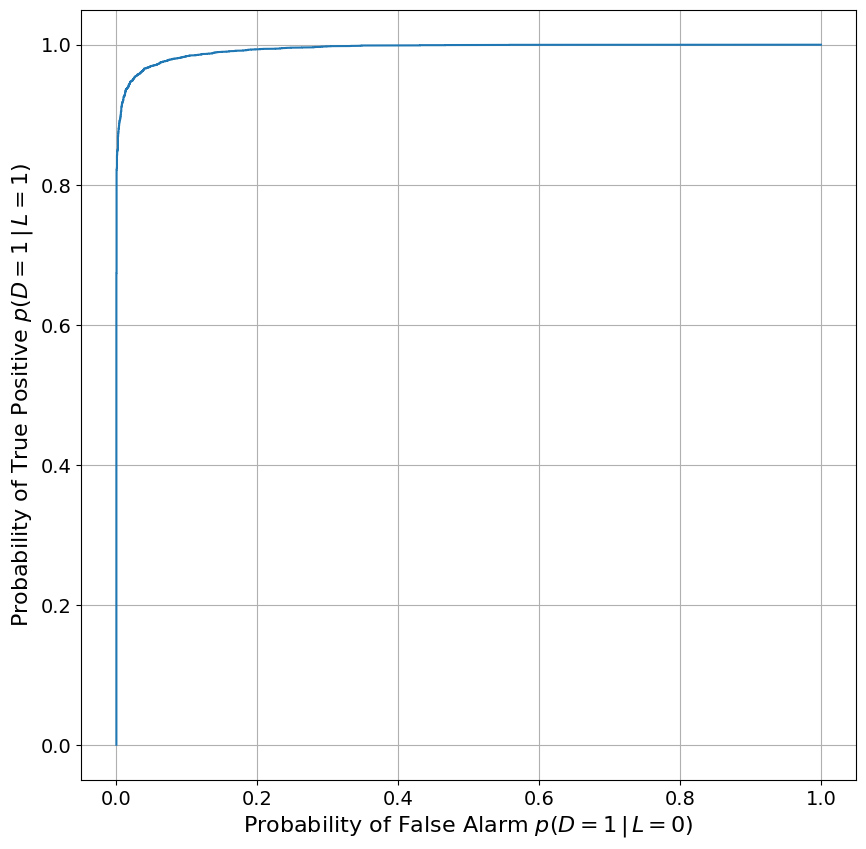

In [6]:


# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], gmm_pdf['Sigma'][l]) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the Receiver Operating Characteristic ROC for ERM by changing log(gamma) thresholds
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds and 2 rows are the FPR and TPR respectively

#Create a plot for the ROC Curve
plt.ioff() # Turn off Interactive plotting
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion() #Turn Interactive plotting back on

# Plot the ROC curve using the calculated FPR and TPR
ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

plt.grid(True) #Add a grid tp the plot
display(fig_roc) #Display the ROC curve plot
fig_roc; #Show the figure



Min Empirical Pr(error) for ERM = 0.036
Min Empirical Gamma = 0.593
Min Theoretical Pr(error) for ERM = 0.037
Min Theoretical Gamma = 0.538


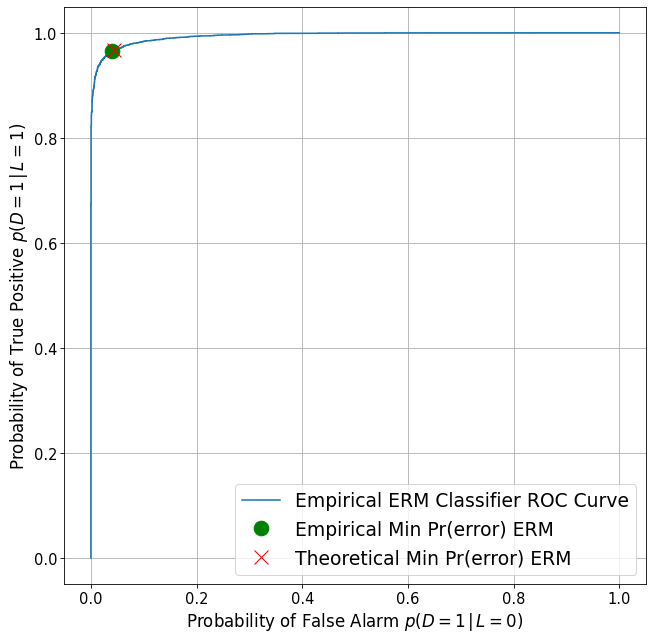

In [7]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['priors'][0] / gmm_pdf['priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * gmm_pdf['priors'][0] + 
                               class_metrics_map['FNR'] * gmm_pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

print("Min Empirical Pr(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

Min Naive Pr(error) for ERM = 0.051
Min Naive Gamma = 0.263


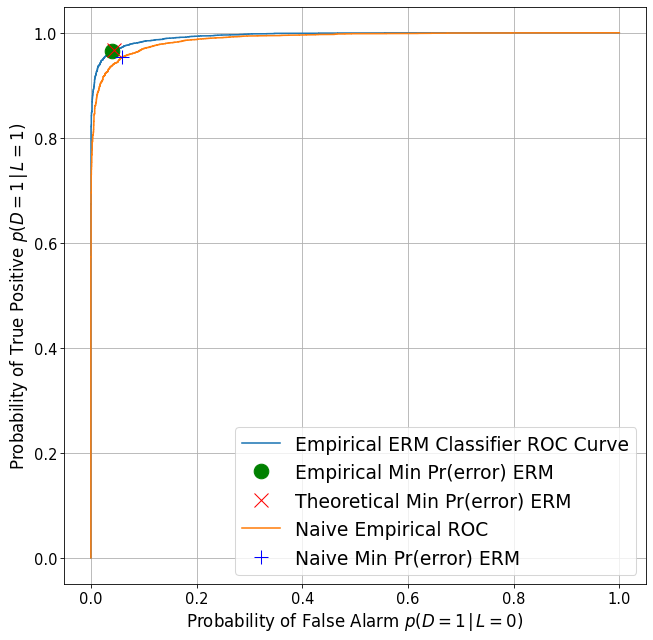

In [8]:
# Happens to be identity matrix in this question
naive_class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], np.eye(n)) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_naive = np.log(naive_class_conditional_likelihoods[1]) - np.log(
    naive_class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_naive, gammas_naive = estimate_roc(discriminant_score_naive, labels)

# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_naive = np.array((roc_naive['p10'], (1 - roc_naive['p11']))).T.dot(N_per_l / N)

# Min prob error for the naive classifier gamma thresholds
min_prob_error_naive = np.min(prob_error_naive)
min_ind_naive = np.argmin(prob_error_naive)

# Plot naive min prob error
ax_roc.plot(roc_naive['p10'], roc_naive['p11'], label="Naive Empirical ROC")
ax_roc.plot(roc_naive['p10'][min_ind_naive], roc_naive['p11'][min_ind_naive], 'b+', label="Naive Min Pr(error) ERM",
            markersize=14)
ax_roc.legend()

print("Min Naive Pr(error) for ERM = {:.3f}".format(min_prob_error_naive))
print("Min Naive Gamma = {:.3f}".format(np.exp(gammas_naive[min_ind_naive])))

display(fig_roc)

Min LDA Pr(error) for ERM = 0.359
Min LDA Gamma = -6.632


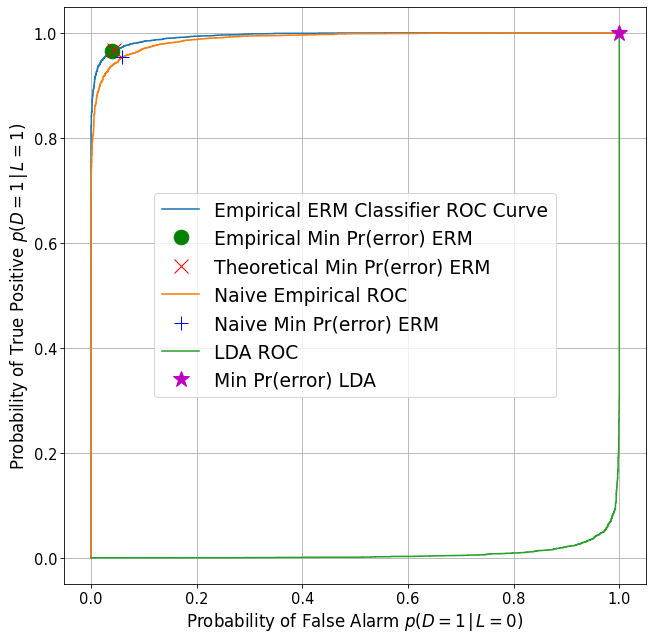

In [9]:
# Fisher LDA Classifer (using sample average estimates for model parameters)
_, discriminant_score_lda = perform_lda(X, labels)

# Estimate the ROC curve for this LDA classifier
roc_lda, gamma_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda['p10'], (1 - roc_lda['p11']))).T.dot(N_per_l / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind_lda = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda['p10'], roc_lda['p11'], label="LDA ROC")
ax_roc.plot(roc_lda['p10'][min_ind_lda], roc_lda['p11'][min_ind_lda], 'm*', label="Min Pr(error) LDA",  markersize=16)
ax_roc.legend()


print("Min LDA Pr(error) for ERM = {:.3f}".format(min_prob_error_lda))
print("Min LDA Gamma = {:.3f}".format(np.real(gamma_lda[min_ind_lda])))

display(fig_roc)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Define the dimensionality of input random vectors and the number of classes
n = 3  # dimensionality of input random vectors
C = 3  # number of classes

# Create a dictionary to store Gaussian Mixture Model (GMM) PDF parameters
gmm_pdf = {}

# Define class priors for 3 classes
gmm_pdf['priors'] = np.array([0.3, 0.3, 0.4])

# Set the average standard deviation for generating the means
average_std = 1.0  # Average standard deviation

# Set mean vectors and covariances to satisfy the requirement
# Mean vector for Class 1
mean_class1 = np.array([0, 0, 0])  # Class 1 mean

# Mean vector for Class 2, approximately 2 to 3 times the average standard deviation away from Class 1
mean_class2 = np.array([2 * average_std, 2 * average_std, 2 * average_std])  # Class 2 mean

# Mean vector for Class 3, approximately 2 to 3 times the average standard deviation away from Class 2
mean_class3 = np.array([3 * average_std, 3 * average_std, 3 * average_std])  # Class 3 mean

# Store the mean vectors in the GMM PDF parameters
gmm_pdf['mu'] = np.array([mean_class1, mean_class2, mean_class3])

# Setting covariance matrices to ensure significant overlap
# We can adjust the covariance matrices accordingly
covariance = 0.5 * np.eye(n) 

# Store the covariance matrices in the GMM PDF parameters
gmm_pdf['Sigma'] = np.array([covariance, covariance, covariance])

# Now the means and covariances satisfy the required conditions


[2963 3095 3942]


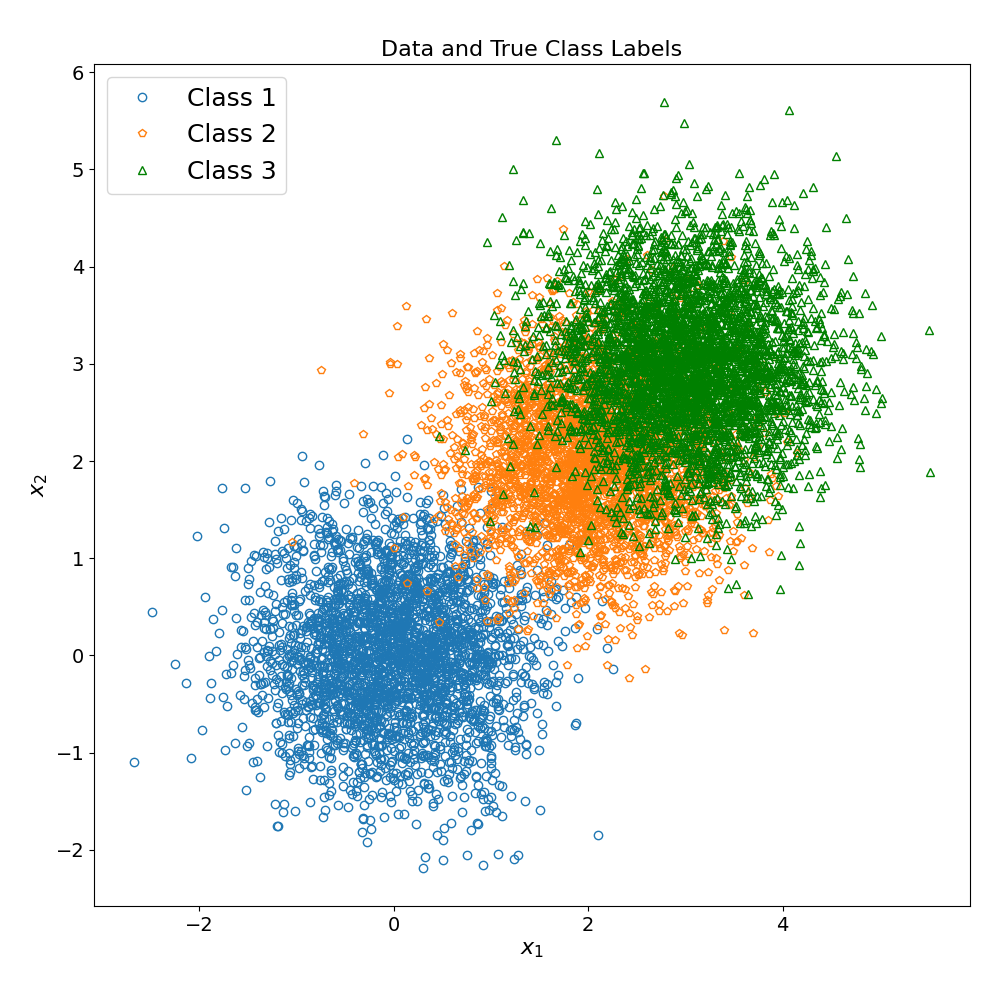

In [11]:
# Define the number of samples to generate
N = 10000;

# Generate synthetic data samples from the specified GMM PDF
X, labels = generate_data_from_gmm(N, gmm_pdf)

# Create an array to represent the class labels
L = np.array(range(C)) 

# Count the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])

# Print the counts of samples in each class
print(N_per_l)

# Create a figure for plotting the data
fig, ax_gmm = plt.subplots(figsize=(10, 10))

# Plot data points for Class 1 with 'o' markers
ax_gmm.plot(X[labels == 0, 0], X[labels == 0, 1], 'o', label="Class 1", markerfacecolor='none')

# Plot data points for Class 2 with 'p' markers
ax_gmm.plot(X[labels == 1, 0], X[labels == 1, 1], 'p', label="Class 2", markerfacecolor='none')

# Plot data points for Class 3 with 'g^' markers
ax_gmm.plot(X[labels == 2, 0], X[labels == 2, 1], 'g^', label="Class 3", markerfacecolor='none')

# Set labels for the x and y axes
ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")

# Set the aspect ratio of the plot to be equal
ax_gmm.set_aspect('equal')


# Set the title of the plot
plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout() # Adjust the layout of the plot for better presentation


# The code generates data samples from the GMM and visualizes the data and true class labels.
# The number of samples per class is calculated, and the data is plotted with different markers
# for each class. The plot is labeled, and a legend is displayed for class labels.

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 789
Empirically Estimated Probability of Error: 0.0789


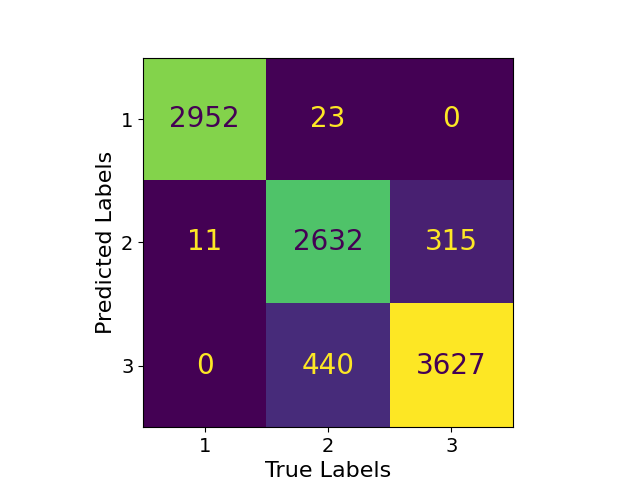

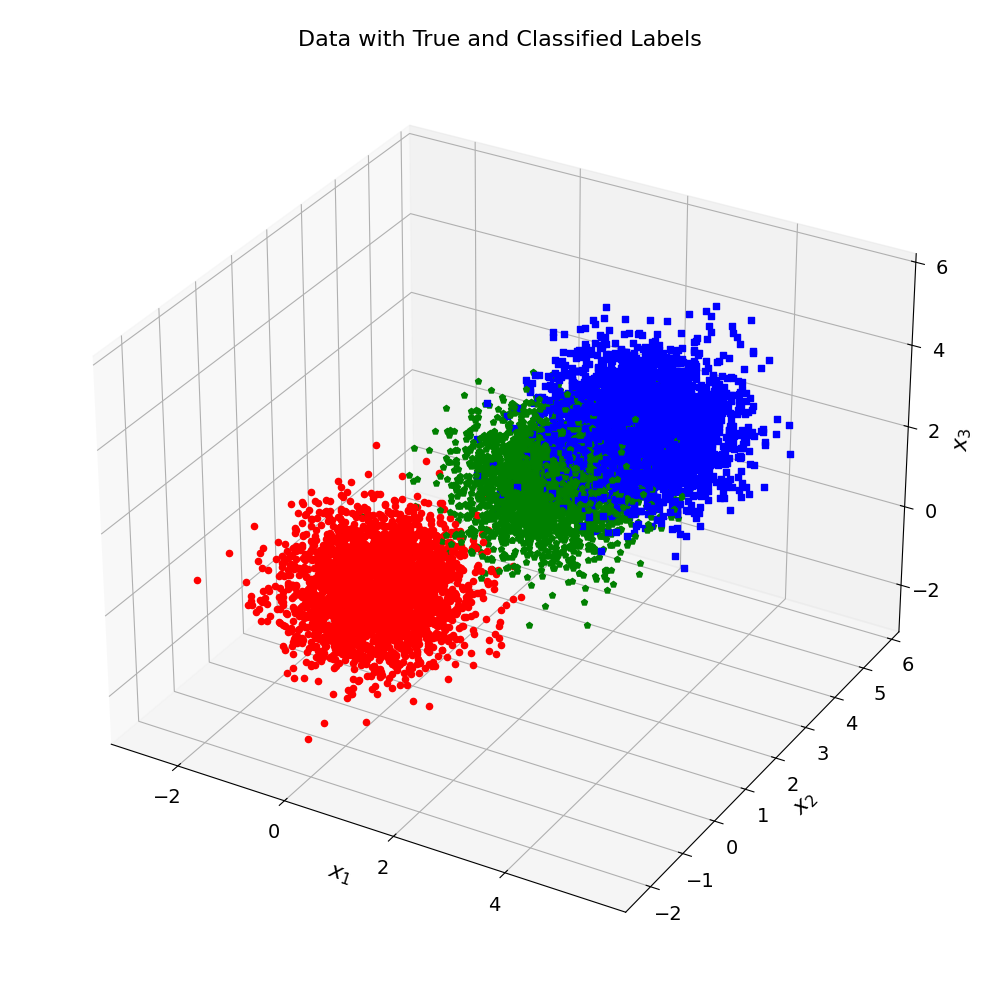

In [12]:
# Define the loss matrix Lambdas for the ERM decision rule
Lambdas = np.ones((C, C)) - np.eye(C)

# Use the ERM (Empirical Risk Minimization) decision rule to determine class predictions
decision_map = perform_erm_classification(X, Lambdas, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")

# Compute the confusion matrix
conf_mat1 = confusion_matrix(decision_map, labels)

# Create a display for the confusion matrix
conf_display = ConfusionMatrixDisplay.from_predictions(decision_map, labels, display_labels=['1', '2', '3',], colorbar=False)

# Set labels for the y-axis (predicted labels) and x-axis (true labels)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

# Calculate the total number of misclassified samples 
correct_class_samples1 = np.sum(np.diag(conf_mat1))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples1))

# Compute the empirically estimated probability of error
prob_error1 = 1 - (correct_class_samples1 / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error1))

from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting functionality
# Visualize the data with true class labels and classification results
fig = plt.figure(figsize=(10, 10))
ax_gmm = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

class_markers = ['o', 'p', 's']  # Use different markers for each class
class_colors = ['r', 'g', 'b']  # Use different colors for each class

# Iterate through samples and labels to plot data points
for i in range(N):
    class_index = int(labels[i])  # Assuming labels range from 0 to 2
    marker_style = class_markers[class_index]
    marker_color = class_colors[class_index]
    
    ax_gmm.scatter(X[i, 0], X[i, 1], X[i, 2], marker=marker_style, c=marker_color)


ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
ax_gmm.set_zlabel(r"$x_3$")

plt.title("Data with True and Classified Labels")
plt.tight_layout()

# This section of code calculates the confusion matrix for classification, 
# displays the confusion matrix, and computes the probability of error. 
# The loss matrix 'Lambdas' is used for the ERM decision rule, and the results are presented." 

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 1469
Empirically Estimated Probability of Error: 0.1469


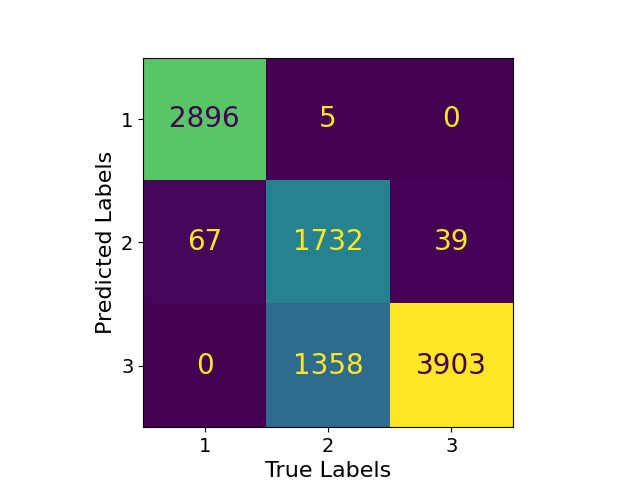

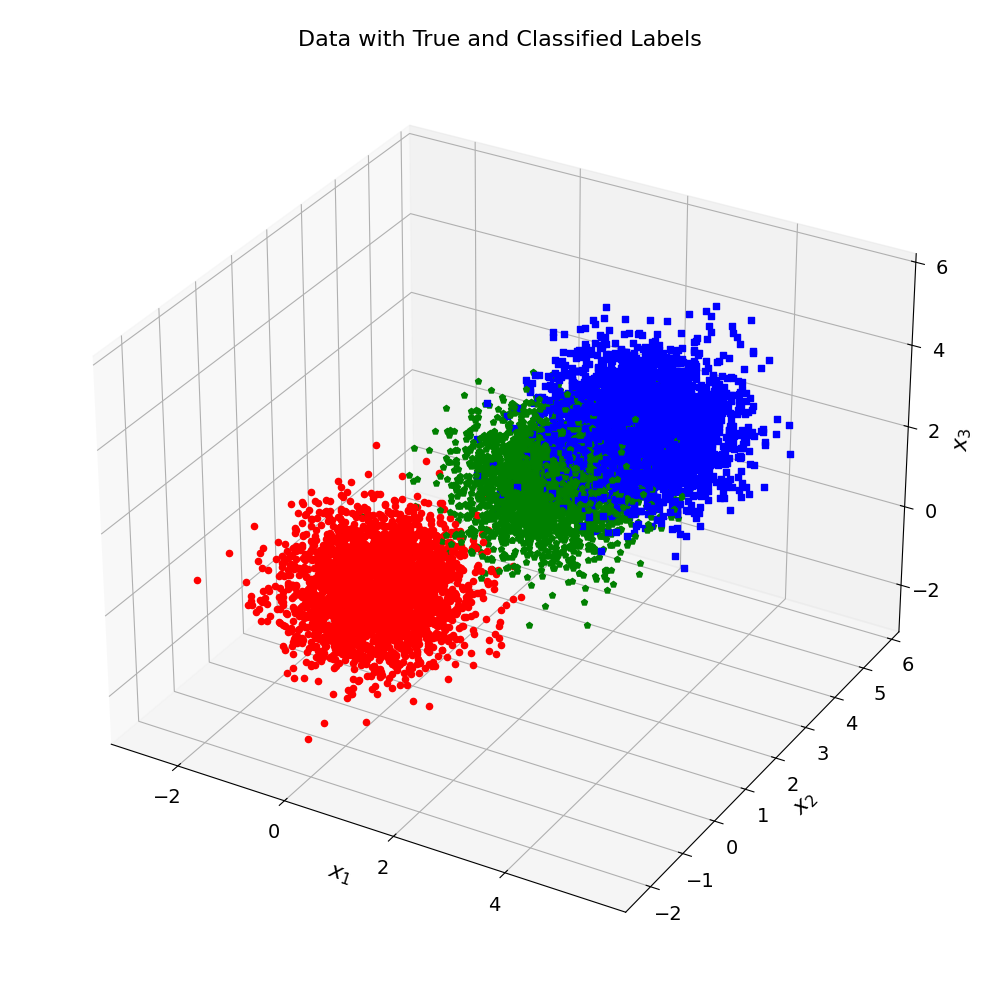

In [17]:
# Define the loss matrix Lambdas for the ERM decision rule
Lambdas = np.array([[0,10,10],[1,0,10],[1,1,0]])

# Use the ERM (Empirical Risk Minimization) decision rule to determine class predictions
decision_map = perform_erm_classification(X, Lambdas, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")

# Compute the confusion matrix
conf_mat2 = confusion_matrix(decision_map, labels)

# Create a display for the confusion matrix
conf_display = ConfusionMatrixDisplay.from_predictions(decision_map, labels, display_labels=['1', '2', '3',], colorbar=False)

# Set labels for the y-axis (predicted labels) and x-axis (true labels)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

# Calculate the total number of misclassified samples 
correct_class_samples2 = np.sum(np.diag(conf_mat2))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples2))

# Compute the empirically estimated probability of error
prob_error2 = 1 - (correct_class_samples2 / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error2))

from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting functionality
# Visualize the data with true class labels and classification results
fig = plt.figure(figsize=(10, 10))
ax_gmm = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

class_markers = ['o', 'p', 's']  # Use different markers for each class
class_colors = ['r', 'g', 'b']  # Use different colors for each class

# Iterate through samples and labels to plot data points
for i in range(N):
    class_index = int(labels[i])  # Assuming labels range from 0 to 2
    marker_style = class_markers[class_index]
    marker_color = class_colors[class_index]
    
    ax_gmm.scatter(X[i, 0], X[i, 1], X[i, 2], marker=marker_style, c=marker_color)


ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
ax_gmm.set_zlabel(r"$x_3$")

plt.title("Data with True and Classified Labels")
plt.tight_layout()

# This section of code calculates the confusion matrix for classification, 
# displays the confusion matrix, and computes the probability of error. 
# The loss matrix 'Lambdas' is used for the ERM decision rule, and the results are presented." 

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 2621
Empirically Estimated Probability of Error: 0.2621


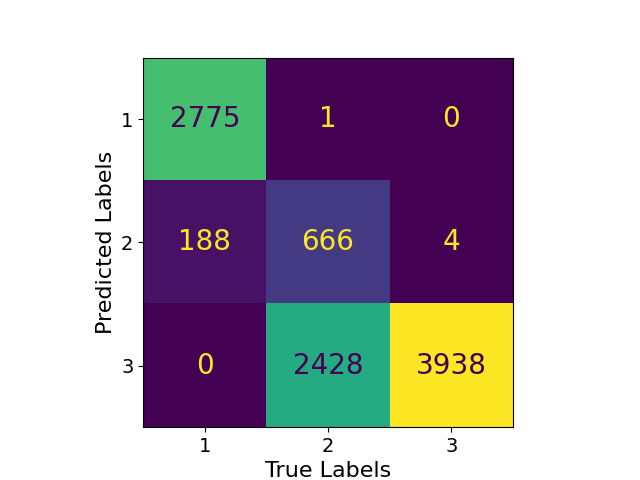

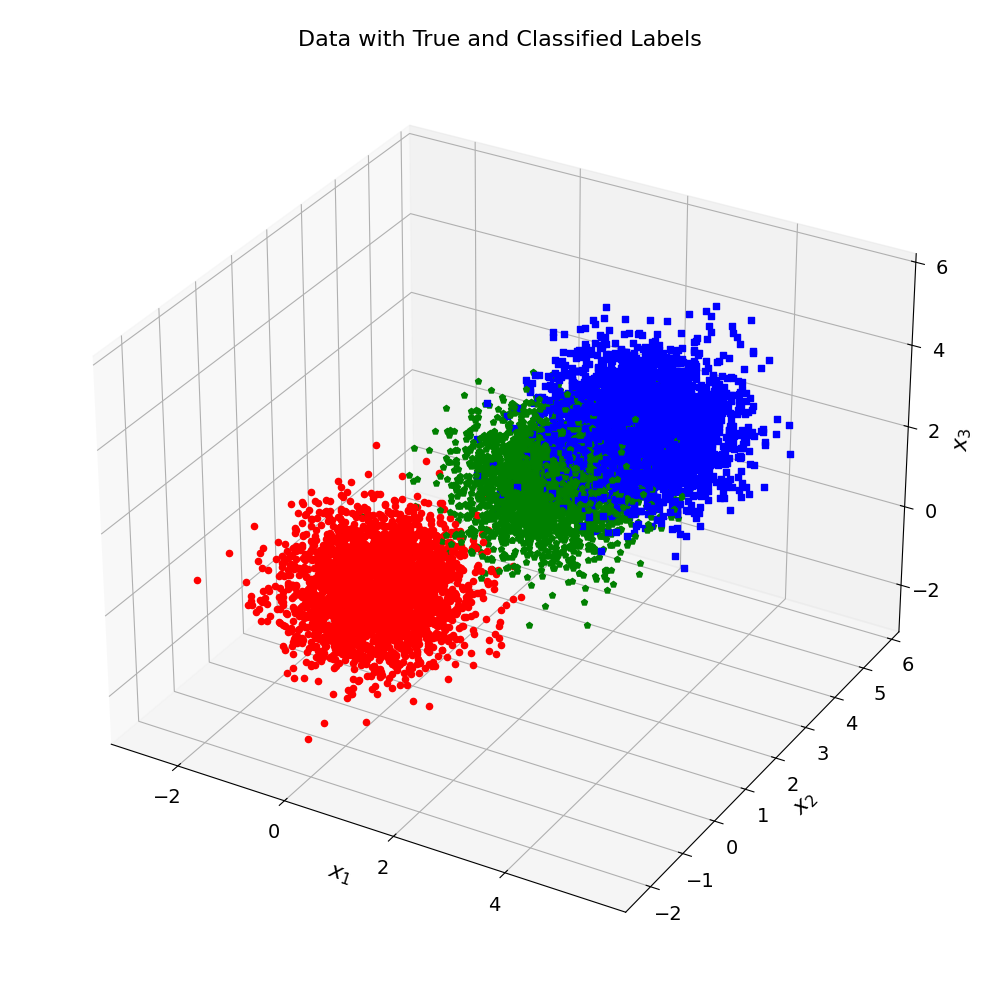

In [18]:
# Define the loss matrix Lambdas for the ERM decision rule
Lambdas = np.array([[0,100,100],[1,0,100],[1,1,0]])

# Use the ERM (Empirical Risk Minimization) decision rule to determine class predictions
decision_map = perform_erm_classification(X, Lambdas, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")

# Compute the confusion matrix
conf_mat3 = confusion_matrix(decision_map, labels)

# Create a display for the confusion matrix
conf_display = ConfusionMatrixDisplay.from_predictions(decision_map, labels, display_labels=['1', '2', '3',], colorbar=False)

# Set labels for the y-axis (predicted labels) and x-axis (true labels)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

# Calculate the total number of misclassified samples 
correct_class_samples3 = np.sum(np.diag(conf_mat3))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples3))

# Compute the empirically estimated probability of error
prob_error3 = 1 - (correct_class_samples3 / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error3))

from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting functionality
# Visualize the data with true class labels and classification results
fig = plt.figure(figsize=(10, 10))
ax_gmm = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

class_markers = ['o', 'p', 's']  # Use different markers for each class
class_colors = ['r', 'g', 'b']  # Use different colors for each class

# Iterate through samples and labels to plot data points
for i in range(N):
    class_index = int(labels[i])  # Assuming labels range from 0 to 2
    marker_style = class_markers[class_index]
    marker_color = class_colors[class_index]
    
    ax_gmm.scatter(X[i, 0], X[i, 1], X[i, 2], marker=marker_style, c=marker_color)


ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
ax_gmm.set_zlabel(r"$x_3$")

plt.title("Data with True and Classified Labels")
plt.tight_layout()
# This section of code calculates the confusion matrix for classification, 
# displays the confusion matrix, and computes the probability of error. 
# The loss matrix 'Lambdas' is used for the ERM decision rule, and the results are presented." 

In [20]:
import pandas as pd

# URL for the Wine Quality dataset in CSV format
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# Read the dataset with the correct delimiter (semicolon)
wine_df = pd.read_csv(url, delimiter=';')

# Check the first few rows of the DataFrame
print(wine_df.head())


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [21]:
# Define a function to calculate the regularized covariance matrix
def regularized_cov(X, lambda_reg):
    n = X.shape[0]
    sigma = np.cov(X)  # Calculate the covariance matrix
    
    # Apply regularization by adding a scaled identity matrix
    sigma += lambda_reg * np.eye(n)
    return sigma

# Total number of rows/samples in the dataset
N = len(wine_df.index)

# Extract data matrix X and target labels vector from the DataFrame
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to encode labels as integers (0, 1, ..., C)
le = preprocessing.LabelEncoder()
le.fit(qualities) # Fit the encoder on the target labels
labels = le.transform(qualities) # Encode the target labels

# Estimate class priors (the probability of each class)
gmm = {}
gmm['priors'] = (wine_df.groupby(['quality']).size() / N).to_numpy() 
# The class priors are calculated as the relative frequency of each class in the dataset

# Infer the number of classes from the class priors
num_classes = len(gmm['priors'])

# Calculate the mean (average) feature values for each class
gmm['mu'] = wine_df.groupby(['quality']).mean().to_numpy() 
# The 'mu' matrix contains the mean feature values for each class


# Infer the number of features from the class priors (number of columns in the 'mu' matrix)
n = gmm['mu'].shape[1]
# This code computes the covariance matrix for each class by applying regularization


# Calculate the regularized covariance matrix for each class
gmm['Sigma'] = np.array([regularized_cov(X[labels == l].T, (1/n)) for l in range(num_classes)])

# Calculate the number of samples in each class
N_per_l = np.array([sum(labels == l) for l in range(num_classes)])
print(N_per_l) # Print the number of samples per class


[  20  163 1457 2198  880  175    5]


Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 2309
Empirically Estimated Probability of Error: 0.4714


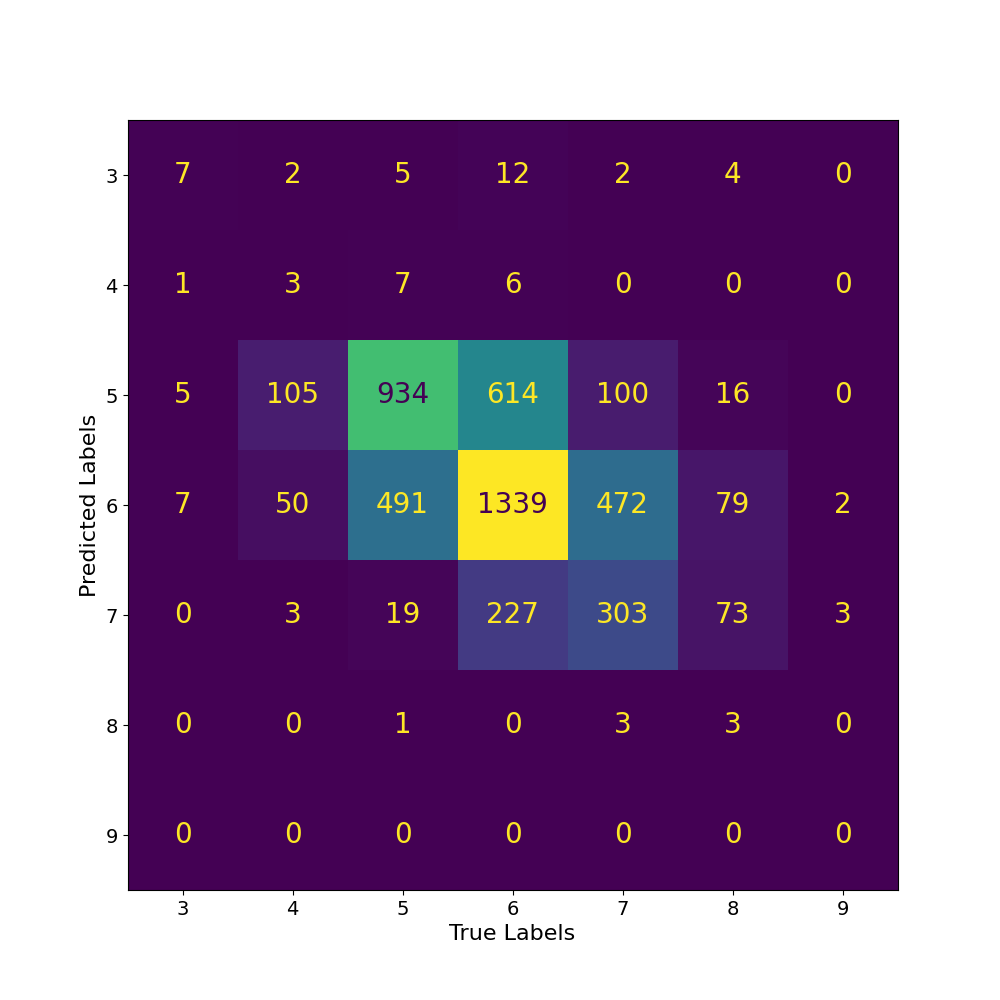

In [22]:
# If the loss function is 0-1 loss (binary classification), yield MAP decision rule; otherwise, use ERM classifier
# Define the loss matrix 'Lambda': penalizes misclassifications based on class separations
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# Perform the Empirical Risk Minimization (ERM) decision rule:
# Determine class predictions based on the loss matrix, feature data, and class priors
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Display the confusion matrix using the sklearn library
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)

# Create a visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax,
                                                       display_labels=['3', '4', '5', '6', '7', '8', '9'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

# Calculate the total number of correctly classified samples
correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

# Compute the empirically estimated Probability of Error:
# The fraction of incorrectly classified samples
prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

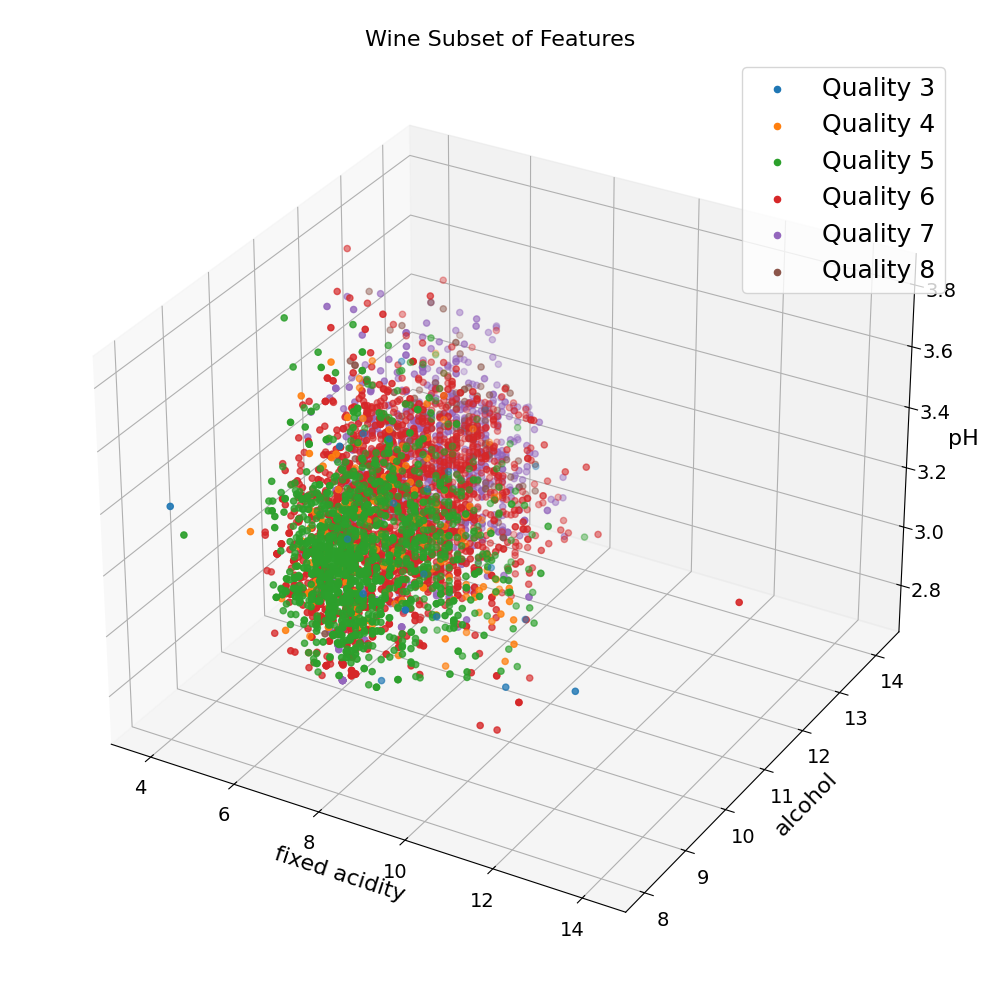

In [23]:
# Create a new figure for the 3D plot with a specified size
fig = plt.figure(figsize=(10, 10))

# Add a subplot with 3D projection to the figure
ax_subset = fig.add_subplot(111, projection='3d')

# Get unique quality values from the 'quality' column of the wine dataset
unique_qualities = np.sort(wine_df['quality'].unique())


# Iterate through the unique quality values for visualization
for q in range(unique_qualities[0], unique_qualities[-1]):
    # Scatter plot points for the current quality level in 3D space
    ax_subset.scatter(wine_df[wine_df['quality']==q]['fixed acidity'], 
                      wine_df[wine_df['quality']==q]['alcohol'], 
                      wine_df[wine_df['quality']==q]['pH'], label="Quality {}".format(q))
    
# Set labels for the three axes in the 3D plot
ax_subset.set_xlabel("fixed acidity")
ax_subset.set_ylabel("alcohol")
ax_subset.set_zlabel("pH")

# Set equal axes for 3D plots to realize the additional challenges in visualization
# ax_subset.set_box_aspect((np.ptp(wine_df['fixed acidity']), np.ptp(wine_df['alcohol']), np.ptp(wine_df['pH'])))

# Set the title of the 3D plot
plt.title("Wine Subset of Features")

# Display the legend to label the data points by quality
plt.legend()

# Adjust the layout for better presentation
plt.tight_layout()

# Show the 3D plot
plt.show()

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


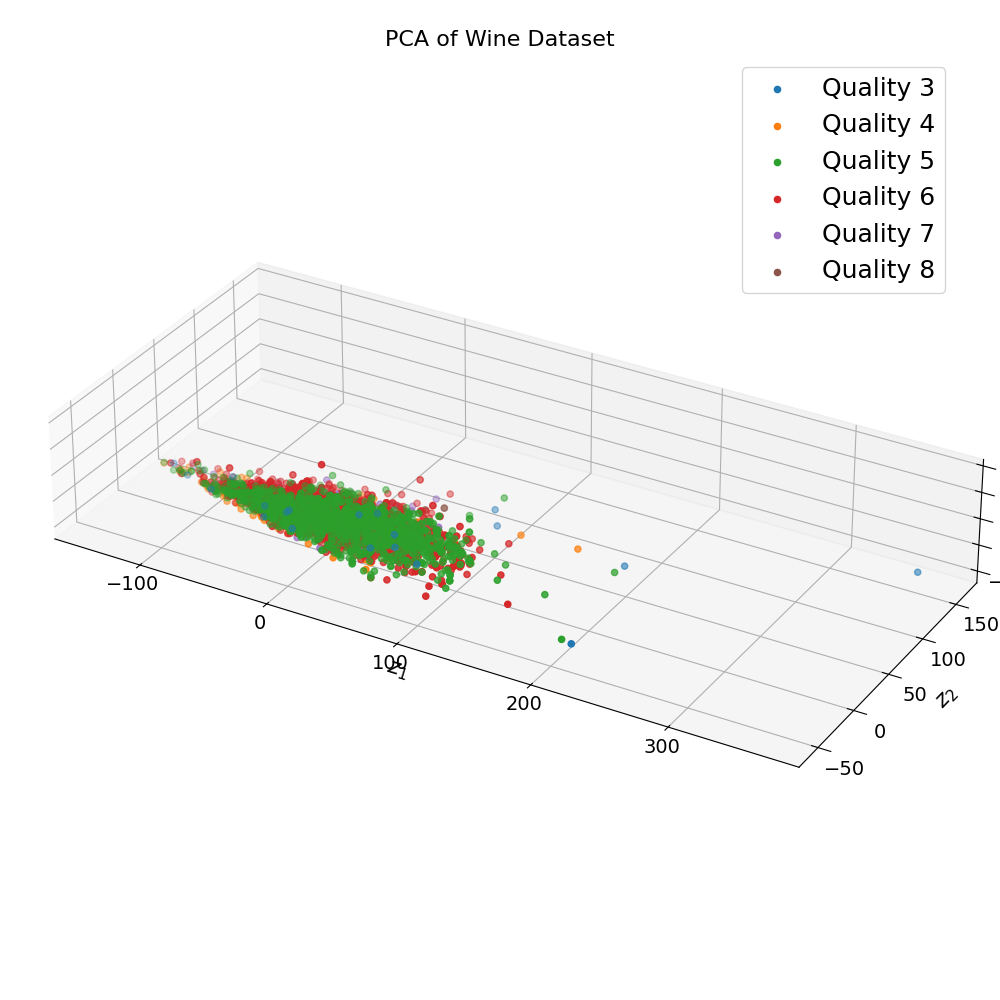

In [24]:
# Create a new figure for the 3D plot with a specified size
fig = plt.figure(figsize=(10, 10))

# Add a subplot with 3D projection to the figure
ax_pca = fig.add_subplot(111, projection='3d')

# Initialize Principal Component Analysis (PCA) with a specific number of components (n_components)
pca = PCA(n_components=3)  # n_components is how many PCs we'll keep

# Fit the PCA model to the dataset and transform it to a lower-dimensional space
X_fit = pca.fit(X)  # This is a fitted estimator, not the actual data to project
Z = pca.transform(X) # Transformed data in a lower-dimensional space

# Print the explained variance ratio for the principal components
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    # Scatter plot points for the PCA-transformed data in 3D space
    ax_pca.scatter(Z[wine_df['quality']==q, 0], 
                      Z[wine_df['quality']==q, 1], 
                      Z[wine_df['quality']==q, 2], label="Quality {}".format(q))

# Set labels for the three PCA axes
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

# Set equal axes for 3D plots to ensure accurate visualization
ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

# Set the title of the 3D PCA plot
plt.title("PCA of Wine Dataset")

# Display the legend to label the data points by quality
plt.legend()

# Adjust the layout for better presentation
plt.tight_layout()

# Show the 3D PCA plot
plt.show()

In [32]:
from urllib.request import urlopen  # library to open URLs
from zipfile import ZipFile  # library for working with ZIP files
from io import BytesIO  # library for working with binary data in memory
from sys import float_info  # provides information about the float type
import matplotlib.pyplot as plt  # library for creating visualizations
import numpy as np  # library for working with arrays and matrices
import pandas as pd  # library for working with data frames
from scipy.stats import norm, multivariate_normal  # statistical functions
from sklearn import preprocessing  # library for scaling and normalizing data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # library for creating confusion matrices
from sklearn.decomposition import PCA  # library for performing PCA
import csv  # library for reading and writing CSV files

# Downloads and reads in the HAR dataset without writing to disk
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip')
har_zip = ZipFile(BytesIO(resp.read()))
har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)

# Concatenates the training and test data frames
har_df = pd.concat([har_train_df, har_test_df])


# Sanity check
har_df


0         1         2         3         4         5         6    \
0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...        ...       ...       ...       ...       ...       ...       ...   
2942  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
2943  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
2944  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
2945  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
2946  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

           7         8         9    ...       551       552       553  \
0    -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304   
1    -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499   
2    -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104   
3    -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845   
4    -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205   
...        ...       ...       ...  ...       ...       ...       ...   
2942 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
2943 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
2944 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
2945 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
2946 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

           554       555       556       557       558       559       560  
0    -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1     0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2    -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3    -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4     0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  
...        ...       ...       ...       ...       ...       ...       ...  
2942 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
2943 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
2944 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
2945  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
2946  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[10299 rows x 561 columns]

Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


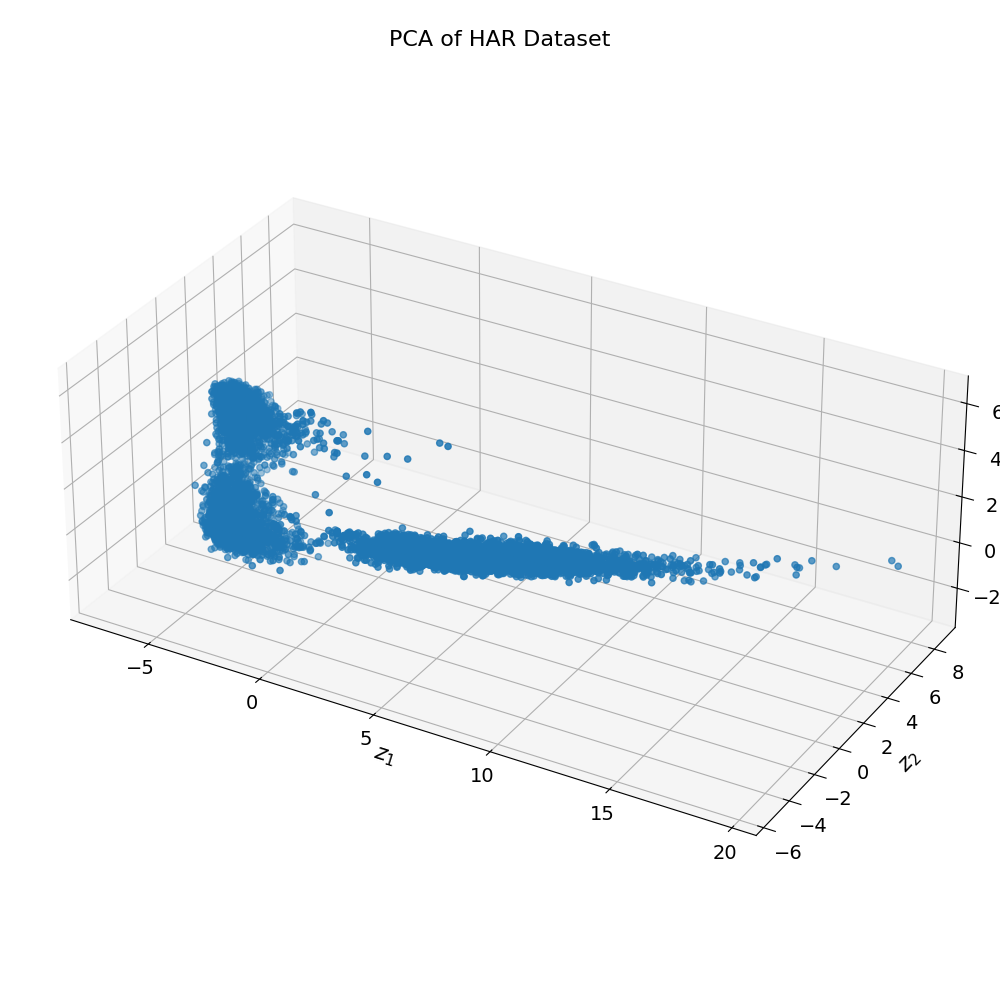

In [33]:
# Extracts the data matrix X
X = har_df.to_numpy()

# Creates a 3D plot to visualize the PCA
fig = plt.figure(figsize=(10, 10))
ax_pca = fig.add_subplot(111, projection='3d')

# Performs PCA with 3 principal components and fits the data
pca = PCA(n_components=3)
X_fit = pca.fit(X)
Z = pca.transform(X)

# Prints out the explained variance ratio of the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

# Plots the transformed data in 3D
ax_pca.scatter(Z[:, 0], Z[:, 1], Z[:, 2])
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")
ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

# Sets the title and displays the plot
plt.title("PCA of HAR Dataset")
plt.tight_layout()
plt.show()